<a href="https://colab.research.google.com/github/thspanos/AI-LAb/blob/main/Thomas_Spanos_Lambda_IDS_to_IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [2]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:
#συνάρτηση εισαγωγής συνόλου δεδομένων
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    X = df.drop('target', axis=1).values
    y = df['target'].values
    return X, y

In [4]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [6]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = load_dataset(csv_file_path)

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()

In [7]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'

In [8]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [9]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)
X = scaler.fit_transform(X)

In [10]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6337 - loss: 0.8122
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8409 - loss: 0.4969
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8723 - loss: 0.4514
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8825 - loss: 0.4304
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8888 - loss: 0.4223
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 800, Training Accuracy: 0.9146, Test Accuracy: 0.9065
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6353 - loss: 0.8189
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8516 - loss: 0.4914
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8688 - loss: 0.4648
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8770 - loss: 0.4381
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8926 - loss: 0.4018
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 1600, Training Accuracy: 0.9156, Test Accuracy: 0.9065
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6414 - loss: 0.8100
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8527 - loss: 0.4658
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8812 - loss: 0.4339
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8801 - loss: 0.4246
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8942 - loss: 0.3969
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 2400, Training Accuracy: 0.9163, Test Accuracy: 0.9068
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6587 - loss: 0.7883
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8526 - loss: 0.4825
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8743 - loss: 0.4517
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8832 - loss: 0.4246
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8900 - loss: 0.4124
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Batch 3200, Training Accuracy: 0.9135, Test Accuracy: 0.9041
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6426 - loss: 0.8048
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8471 - loss: 0.5002
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8700 - loss: 0.4436
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8819 - loss: 0.4302
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8871 - loss: 0.4356
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 4000, Training Accuracy: 0.9148, Test Accuracy: 0.9021
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6358 - loss: 0.8103
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8430 - loss: 0.4930
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8801 - loss: 0.4223
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8846 - loss: 0.4242
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8909 - loss: 0.4139
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 4800, Training Accuracy: 0.9147, Test Accuracy: 0.9045
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6298 - loss: 0.8276
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8443 - loss: 0.5080
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8799 - loss: 0.4306
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8830 - loss: 0.4268
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8929 - loss: 0.3999
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 5600, Training Accuracy: 0.9146, Test Accuracy: 0.9068
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6351 - loss: 0.7955
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8510 - loss: 0.4903
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8739 - loss: 0.4500
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8837 - loss: 0.4210
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8981 - loss: 0.3948
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 6400, Training Accuracy: 0.9156, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6573 - loss: 0.7899
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8497 - loss: 0.4926
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8774 - loss: 0.4416
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8832 - loss: 0.4312
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8889 - loss: 0.4081
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 7200, Training Accuracy: 0.9146, Test Accuracy: 0.9045
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6511 - loss: 0.7995
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8567 - loss: 0.4887
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8767 - loss: 0.4368
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8891 - loss: 0.4089
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8913 - loss: 0.3998
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 8000, Training Accuracy: 0.9146, Test Accuracy: 0.9025


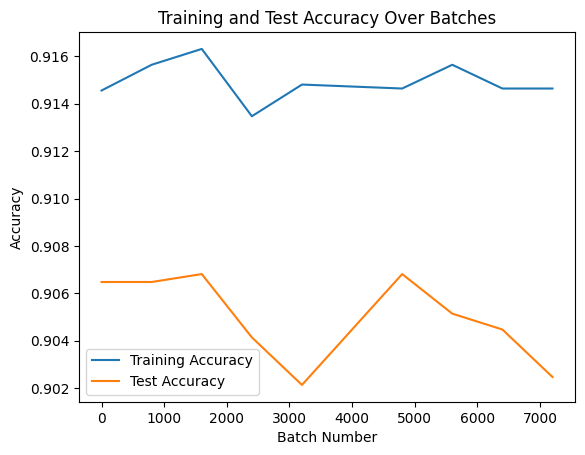

In [11]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler)